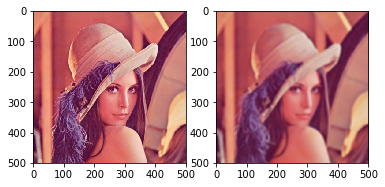

In [6]:
import cv2
from matplotlib import pyplot as plt
image_name = "lena.jpg"
kernel_size=(9,9)
sigma=50

img1=cv2.imread(image_name)
b, g, r = cv2.split(img1)
img= cv2.merge([r,g,b])

plt.subplot(121)
plt.imshow(img)

blur = cv2.GaussianBlur(img,kernel_size,sigma)
plt.subplot(122)
plt.imshow(blur)
plt.show()



In [31]:
import math
import numpy as np
#二维卷积
def conv2d(img,kernel):
    #padding
    height = img.shape[0]
    width = img.shape[1]
    #kernel size为奇数
    padding_size = kernel.shape[0] // 2
    img_padding = np.zeros(shape =(height+2*padding_size,width+2*padding_size))
    img_padding[padding_size:padding_size+height,padding_size:padding_size+width] = img
    result = np.zeros(shape=(height,width))
    for i in range(height):
        for j in range(width):
            conv_result = np.multiply(kernel,img_padding[i:i+2*padding_size+1,j:j+2*padding_size+1])
            result[i][j] = conv_result.sum()
    return result

a = np.array([[1,1,1],[1,1,1],[1,1,1]])
b = np.ones(shape=[5,5])

print conv2d(b,a)




[[ 4.  6.  6.  6.  4.]
 [ 6.  9.  9.  9.  6.]
 [ 6.  9.  9.  9.  6.]
 [ 6.  9.  9.  9.  6.]
 [ 4.  6.  6.  6.  4.]]


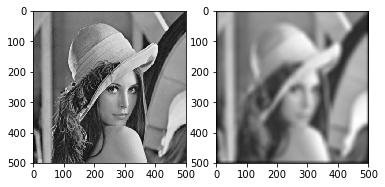

In [72]:
#源码实现高斯模糊
#只能输入灰度图
#不知道彩色图的高斯模糊的策略是什么
from __future__ import division
import math
import numpy as np

#二维卷积
def conv2d(img,kernel):
    #padding
    height = img.shape[0]
    width = img.shape[1]
    #kernel size为奇数
    padding_size = kernel.shape[0] // 2
    img_padding = np.zeros(shape =(height+2*padding_size,width+2*padding_size))
    img_padding[padding_size:padding_size+height,padding_size:padding_size+width] = img
    result = np.zeros(shape=(height,width))
    for i in range(height):
        for j in range(width):
            conv_result = np.multiply(kernel,img_padding[i:i+2*padding_size+1,j:j+2*padding_size+1])
            result[i][j] = conv_result.sum()
    return result
class myGaussianBlur():
    def __init__(self,radius,sigma):
        self.radius = radius
        self.sigma = sigma
    #二维高斯函数
    def __gaussian__(self,x,y):
        res1 = 1/(2*math.pi*self.sigma**2)
        res2 = math.exp(-(x**2+y**2)/(2*self.sigma*self.sigma))
        return res1*res2
    #计算高斯模板
    def __template__(self):
        sideLength=self.radius*2+1  
        result = np.zeros((sideLength, sideLength))  
        for i in range(sideLength):  
            for j in range(sideLength):  
                result[i,j]=self.__gaussian__(i-self.radius, j-self.radius)  
        all=result.sum()  
        return result/all
    #使用模板与原始图像做卷积操作
    def filter(self,img):
        template = self.__template__()
        result = np.zeros(shape=img.shape)
        #for i in range(img.shape[-1]):
        result = conv2d(img,template)
        return result

if __name__=="__main__":
    radius = 11
    sigma = 10
    
    gaussianBlur = myGaussianBlur(radius,sigma)
    img=cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
    #b, g, r = cv2.split(img)
    #img= cv2.merge([r,g,b])
    plt.subplot(121)
    plt.imshow(img,cmap='gray')
    blur = gaussianBlur.filter(img)
    plt.subplot(122)
    #b, g, r = cv2.split(blur)
    plt.imshow(blur,cmap='gray')
    plt.show()

In [79]:
#coding:utf-8
import os
 
def getallfiles(path):
    allfile=[]
    for dirpath,dirnames,filenames in os.walk(path):
        for dir in dirnames:
            allfile.append(os.path.join(dirpath,dir))
        for name in filenames:
            allfile.append(os.path.join(dirpath, name))
            
    return allfile
if __name__ == '__main__':
    path = "/home/lrh/program/git"
    allfile=getallfiles(path)
    for file in allfile:
        print file
        raw_input("wait")

/home/lrh/program/git/pytorch-example
wait
/home/lrh/program/git/texexample
wait
/home/lrh/program/git/trend_ml_tools
wait
/home/lrh/program/git/cplusexample
wait
/home/lrh/program/git/conv_arithmetic
wait
/home/lrh/program/git/kaggle
wait
/home/lrh/program/git/malware_2017_10
wait
/home/lrh/program/git/malware
wait
/home/lrh/program/git/pytorch-capsule
wait
/home/lrh/program/git/PatternRecognitionAssignment
wait
/home/lrh/program/git/logo_detect
wait
/home/lrh/program/git/vision
wait
/home/lrh/program/git/pytorch
wait
/home/lrh/program/git/blog
wait
/home/lrh/program/git/tensorflow-example
wait
/home/lrh/program/git/DCGAN-tensorflow
wait
/home/lrh/program/git/tensorlayer
wait
/home/lrh/program/git/pytorch-example/.ipynb_checkpoints
wait
/home/lrh/program/git/pytorch-example/capsulenet
wait
/home/lrh/program/git/pytorch-example/pytorch_visdom
wait
/home/lrh/program/git/pytorch-example/cifar-unbalance


KeyboardInterrupt: 